# 회고

**배운 점: LSTM의 인코더와 디코더를 통해서 출력을 하는 코드를 확인함**

**아쉬운 점: LSTM의 구조에 대해서 이해를 제대로 하지 못하고 있다는 점을 확인함**

**느낀 점: LSTM, 어텐션을 더 공부해야겠다고 생각함**

**어려웠던 점: 성능 개선을 위한 방법론을 어떻게 적용해야할 지 몰라서 어려웠음. 먼저 언어모델은 너무 어려웠다. 일단 모델을 이해하기 쉽지 않아서 모델을 개선할 엄두도 내지 못했다. 트랜스 포머로 바꾸어 진행해 볼려고 했지만 너무나 어려워서 중간에 멈출 수 밖에 없었다. 다음에는 더 공부해서 제대로 구현해 보고 싶다.**

In [1]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

2024-08-14 09:44:14.042366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 09:44:14.165012: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 09:44:14.202536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 09:44:14.433318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 09:44:15.855786: W tensorflow/compiler/tf2

3.8.2
2.17.0
2.2.2
1.2.0


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
2118,No one sacked Anil Kumble as head coach: VVS L...,"Ex-India batsman VVS Laxman, during an event, ..."
34804,Supreme Court allows Sahara to sell part of Aa...,The Supreme Court has allowed the Sahara Group...
38389,Aren't you a man: Kerala MLA asks transgender ...,Kerala Janapaksham MLA PC George asked a trans...
53456,Wanted to take an Uber and leave for hotel at ...,South Africa's batting coach Dale Benkenstein ...
2143,"Watson's 5-year-old son enters ground, takes h...",Sydney Thunder all-rounder Shane Watson's five...
34898,"FB, Microsoft pledge to defend against misuse ...","Facebook, Microsoft and 32 other global techno..."
19362,"Aishwarya was not offered 'Padmaavat', 'Bajira...","Aishwarya Rai, who had earlier claimed that Sa..."
19669,Basic aircraft price in Rafale deal 9% cheaper...,"Talking about Rafale deal, Finance Minister Ar..."
44810,Shami's wife accuses him of extra-marital affa...,Indian pacer Mohammad Shami's wife Hasin Jahan...
16843,Sunny Leone unveils her wax statue at Delhi's ...,Actress Sunny Leone unveiled her wax statue at...


In [4]:
nltk.download('stopwords')

import numpy as np
import os
import re
import matplotlib.pyplot as plt

# stopwords는 자연어 처리에서 자주 사용되는 불용어 목록을 제공
from nltk.corpus import stopwords

# BeautifulSoup은 HTML 및 XML 문서에서 데이터를 파싱하고 추출하는 데 사용
from bs4 import BeautifulSoup

# TensorFlow Keras의 preprocessing.text 모듈에서 Tokenizer 클래스를 가져옴. Tokenizer는 텍스트를 정수 시퀀스로 변환하는 데 사용
from tensorflow.keras.preprocessing.text import Tokenizer

# 시퀀스의 길이를 맞추기 위해 패딩을 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

#urllib.request는 웹에서 데이터를 요청하고 다운로드하는 데 사용
import urllib.request

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /home/x/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
data.head()

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...


In [27]:
data = data.rename(columns={'headlines': 'Summary'})
data = data.rename(columns={'text': 'Text'})

In [31]:
# 열 이름을 가져옵니다.
cols = data.columns.tolist()

# 첫 번째와 두 번째 열의 순서를 바꿉니다.
cols[0], cols[1] = cols[1], cols[0]

# 데이터프레임에 새로운 열 순서를 적용합니다.
data = data[cols]

In [32]:
data.head()

,Text,Summary
0,saurav kant an alumnus of upgrad and iiit pg p...,upgrad learner switches career ml al salary hike
1,kunal shah credit card bill payment platform c...,delhi techie wins free food swiggy one year cred
2,new zealand defeated india by wickets in the f...,new zealand end rohit sharma led india match w...
3,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan helps customer...
4,speaking about the sexual harassment allegatio...,known hirani yrs metoo claims true sonam


In [30]:
print(data['Summary'][0])

upgrad learner switches career ml al salary hike


In [33]:
data = data[['Text', 'Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
91162,national conference leader farooq abdullah on ...,kupwara attack used spread hatred muslims farooq
80302,the department of primary and secondary educat...,karnataka schools colleges sensitive zones
37857,portugal captain cristiano ronaldo bust at the...,ronaldo bust hometown replaced day hat trick
65106,portugal interior minister constan urbano de s...,portugal interior minister resigns wildfires kill
3950,kerala government has approved its departments...,kerala invites startups projects worth crore
5172,chinese commerce giant jd com billionaire foun...,chinese billionaire charged rape probe us
27311,sanjeev shrivastava dubbed as dancing uncle on...,viral dancing uncle dances hrithik kaho naa py...
41616,former australia captain steve smith broke dow...,regret forever smith breaks apologising
83310,budget carrier spicejet stock has surged this ...,spicejet world top airline stock gain
51426,russia and china growing military capability i...,russia china bigger threats us terrorism us


# 데이터 전처리하기 (추상적 요약)

In [34]:
# .nunique() 메서드는 선택된 열에서 유일한 값의 수를 계산. 즉, 중복을 제외한 고유한 값의 개수를 반환
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98242
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98161


In [35]:
# drop_duplicates 중복행 제거
# subset = ['Text'], Text 열 기준으로 중복행 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98242


In [36]:
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [37]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98242


In [38]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [39]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [40]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [41]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [42]:
# Text 컬럼에 대해 전처리 적용
for i in range(len(data)):
    data.iloc[i, data.columns.get_loc('Text')] = preprocess_sentence(data.iloc[i, data.columns.get_loc('Text')], remove_stopwords=True)


In [43]:
# Summary 컬럼에 대해 전처리 적용
for i in range(len(data)):
    data.iloc[i, data.columns.get_loc('Summary')] = preprocess_sentence(data.iloc[i, data.columns.get_loc('Summary')], remove_stopwords=False)

In [44]:
data['Text']

0        saurav kant alumnus upgrad iiit pg program mac...
1        kunal shah credit card bill payment platform c...
2        new zealand defeated india wickets fourth odi ...
3        aegon life iterm insurance plan customers enjo...
4        speaking sexual harassment allegations rajkuma...
                               ...                        
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98399    new music video shows rapper snoop dogg aiming...
98400    madhesi morcha alliance seven political partie...
Name: Text, Length: 98242, dtype: object

In [45]:
data['Summary']

0         upgrad learner switches career ml al salary hike
1         delhi techie wins free food swiggy one year cred
2        new zealand end rohit sharma led india match w...
3        aegon life iterm insurance plan helps customer...
4                 known hirani yrs metoo claims true sonam
                               ...                        
98396           crpf jawan axed death maoists chhattisgarh
98397        first song sonakshi sinha noor titled uff yeh
98398                       matrix film get reboot reports
98399    snoop dogg aims gun clown dressed trump new video
98400    madhesi morcha withdraws support nepalese gove...
Name: Summary, Length: 98242, dtype: object

In [46]:
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [47]:
data.isnull().sum()

Text       0
Summary    0
dtype: int64

In [48]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98242


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.100445837829035
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.136896642983652


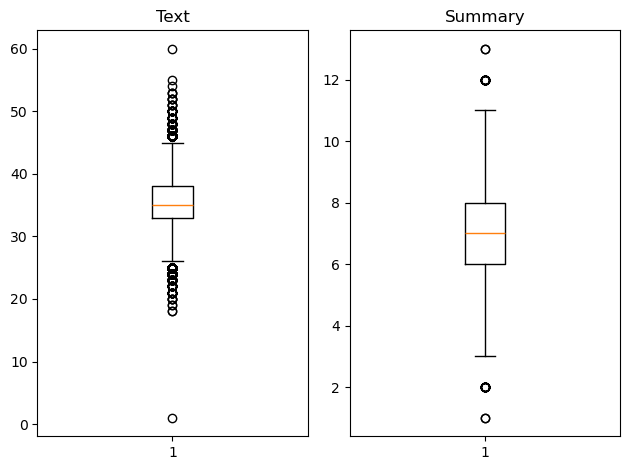

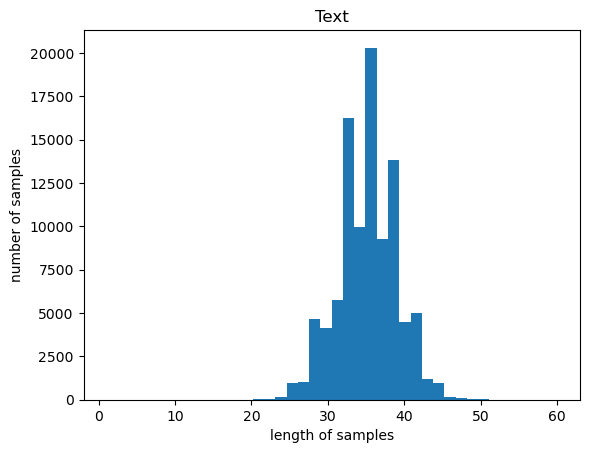

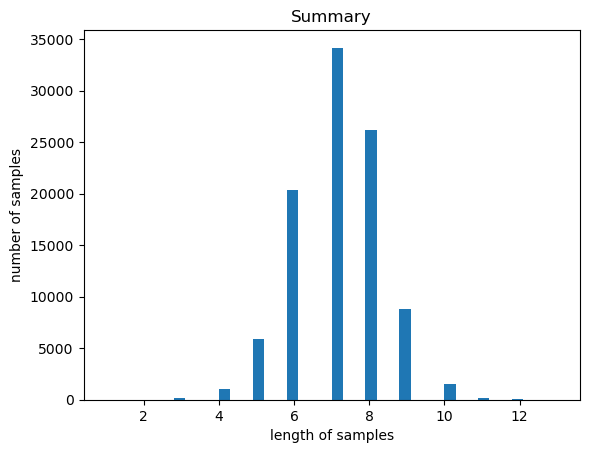

In [49]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [50]:
text_max_len = 50
summary_max_len = 8

In [51]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [52]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998574947578429
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8924797947924513


In [53]:
# 조건 함수 정의
def filter_by_length(row, max_text_len, max_summary_len):
    return len(row['Text'].split()) <= max_text_len and len(row['Summary'].split()) <= max_summary_len

# DataFrame 필터링
data = data[data.apply(lambda row: filter_by_length(row, text_max_len, summary_max_len), axis=1)]

In [54]:
data.head()

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches career ml al salary hike
4,speaking sexual harassment allegations rajkuma...,known hirani yrs metoo claims true sonam
6,india recorded lowest odi total new zealand ge...,india get lowest odi total new zealand
7,weeks ex cbi director alok verma told departme...,govt directs alok verma join work day retirement
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll rajasthan takes total...


In [55]:
data.head()

,Text,Summary
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches career ml al salary hike
4,speaking sexual harassment allegations rajkuma...,known hirani yrs metoo claims true sonam
6,india recorded lowest odi total new zealand ge...,india get lowest odi total new zealand
7,weeks ex cbi director alok verma told departme...,govt directs alok verma join work day retirement
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll rajasthan takes total...


In [56]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 87672


In [57]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches career ml al salary hike,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
4,speaking sexual harassment allegations rajkuma...,known hirani yrs metoo claims true sonam,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken
6,india recorded lowest odi total new zealand ge...,india get lowest odi total new zealand,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
7,weeks ex cbi director alok verma told departme...,govt directs alok verma join work day retirement,sostoken govt directs alok verma join work day...,govt directs alok verma join work day retireme...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll rajasthan takes total...,sostoken cong wins ramgarh bypoll rajasthan ta...,cong wins ramgarh bypoll rajasthan takes total...


In [58]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [59]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[32523 54487 17303 ... 27302 72617 44372]


In [60]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [61]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17534


In [62]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 70138
훈련 레이블의 개수 : 70138
테스트 데이터의 개수 : 17534
테스트 레이블의 개수 : 17534


In [63]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [64]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65933
등장 빈도가 6번 이하인 희귀 단어의 수: 44990
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20943
단어 집합에서 희귀 단어의 비율: 68.23593648097311
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7355859370213187


In [65]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [66]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[721, 553, 277, 382, 610, 1717, 1922, 410, 503, 104, 431, 146, 192, 77, 6628, 757, 656, 382, 1, 1922, 410, 104, 22, 1340, 1692, 674, 6628, 863, 10, 26], [72, 1934, 1412, 592, 519, 158, 11, 73, 1681, 208, 72, 865, 75, 11, 5, 1369, 866, 2220, 748, 804, 134, 73, 989, 6722, 4660, 946, 3129, 3769, 858, 1934, 2009, 433], [72, 459, 625, 4399, 265, 433, 1843, 2723, 162, 1827, 70, 213, 1843, 3130, 56, 727, 3596, 5, 162, 1827, 459, 1179, 1244, 393, 73, 929, 73, 234, 1737, 962, 172, 279, 5235, 164, 2043, 56]]


In [67]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [68]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28446
등장 빈도가 5번 이하인 희귀 단어의 수: 18789
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9657
단어 집합에서 희귀 단어의 비율: 66.05146593545666
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.499326035971249


In [69]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 505, 1210, 28, 90], [1, 1270, 261, 112, 211], [1, 121, 1021, 807, 46, 63, 1839, 139], [1, 160, 82, 181, 455, 1371], [1, 174, 823, 1301, 180, 79, 1782]]
target
decoder  [[505, 1210, 28, 90, 2], [1270, 261, 112, 211, 2], [121, 1021, 807, 46, 63, 1839, 139, 2], [160, 82, 181, 455, 1371, 2], [174, 823, 1301, 180, 79, 1782, 2]]


In [70]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 245
삭제할 테스트 데이터의 개수 : 43
훈련 데이터의 개수 : 69893
훈련 레이블의 개수 : 69893
테스트 데이터의 개수 : 17491
테스트 레이블의 개수 : 17491


In [71]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [72]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

I0000 00:00:1723599198.037709    4589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723599198.310891    4589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723599198.311075    4589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723599198.313636    4589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723599198.313693    4589 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [73]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [74]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  1,024,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │    256,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │    514,000 │ lstm_3[0][0]      │
│                     │ 2000)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,633,104 (13.86 MB)

 Trainable params: 3,633,104 (13.86 MB)

 Non-trainable params: 0 (0.00 B)

# 어텐션 메커니즘 사용하기 (추상적 요약)

In [75]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  1,024,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │    256,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 50, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None,      │  1,026,000 │ concat_layer[0][… │
│                     │ 2000)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,145,360 (15.81 MB)

 Trainable params: 4,145,360 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2024-08-14 10:33:50.680875: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


274/274 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - loss: 4.7729 - val_loss: 4.2830
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - loss: 4.2602 - val_loss: 4.2307
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 4.2149 - val_loss: 4.1414
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - loss: 4.0958 - val_loss: 4.1101
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - loss: 4.0219 - val_loss: 3.9653
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - loss: 3.9052 - val_loss: 3.8935
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - loss: 3.7895 - val_loss: 3.8459
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - loss: 3.6685 - val_loss: 3.7121
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 3.5657 - val_loss: 3.7233
Epoch 10/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - loss: 3.4796 - val_loss: 3.6185
Epoch 11/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - loss: 3.4020 - val_loss: 3.5161
Epoch 12/50
274/274 ━━━━━━━━━━━━━━━━━━━━

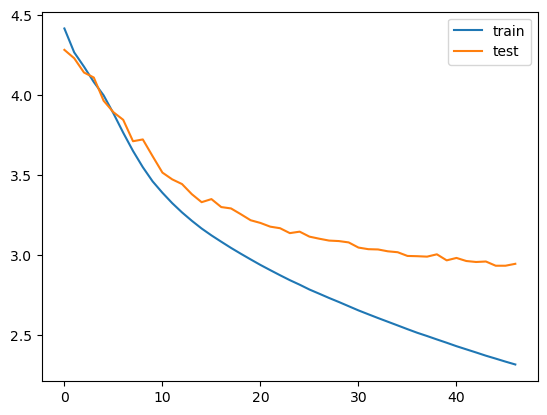

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [78]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 실제 결과와 요약문 비교하기 (추상적 요약)

In [79]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [80]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [81]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [82]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if i == 'eostoken':
            break  # 종료 토큰을 만나면 변환을 종료
        if i != 'sostoken' and i != 0:
            temp = temp + src_index_to_word.get(i, '') + ' '  # 인덱스에 해당하는 단어를 추가
    return temp.strip()  # 앞뒤 공백 제거

In [83]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : cm chandrababu naidu nearly finalised design andhra pradesh metre high assembly building would make world tallest statue gujarat statue unity metres proposed structure shaped like upside three floors state expects process take two years minister narayana said 
실제 요약 : said system victim film lok president
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
예측 요약 :  chhattisgarh cm announces lakh hospital


원문 : year old kashmiri arrested new york charges sexually abusing minor girl avoided trial guilty deportation authorities said hussain arrested march charged first degree sexual abuse welfare child 
실제 요약 : said ask union whose pictures year
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━

# Summa을 이용해서 추출적 요약해보기

In [84]:
import requests
from summa.summarizer import summarize

In [93]:
data_text_raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [121]:
x = 6
text = data_text_raw.loc[x, 'text']
print(text[:1500])
print('\nSumma Summary:')
print(summarize(text, words=10))
print('\nRaw Data headline:')
print(data_text_raw['headlines'][x])

India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.

Summa Summary:
India's previous lowest ODI total in New Zealand was 108.

Raw Data headline:
India get all out for 92, their lowest ODI total in New Zealand


# 요약

**아마존의 상품 리뷰보다 일반 기사의 요약 품질은 상당히 떨어지고 불확실하게 보였음. 추상적 요약을 개선할 수 있는 방법을 찾아봐야하겠음**

**Summa 또한 어느 정도 요약 품질이 조금 더 낫다고 할 수도 있겠지만, 경우에 따라서 요약 결과 자체를 내놓지 못하는 경우도 있었고, 부정확한 정보를 요약한 부분도 있었음**